src/__init__.py

In [6]:
!pip install bayesian-optimization
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=cedd8860e2b0b7e970a0e649393fe6a133599ce415006d8d344372aec2baa7e1
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [59]:
# Basic imports
import pandas as pd
import numpy as np
import time
from math import sqrt
import pickle

# Model imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor

# sklearn support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization

# visualization
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# metrics import
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
from eli5.sklearn import PermutationImportance
from eli5 import explain_weights_df

# Filtering out warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #to ignore FutureWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore") #to ignore all warning messages, regardless of their category.


src/configs.py

In [39]:
param_space = {
    'rf_':
    {
        'max_depth': (8, 30),
        'n_estimators': (50, 300),
        'max_samples': (.25, .6),
        'min_samples_split': (3, 10)
    },

    'lg_':
    {
        'num_leaves': (20, 250),
        'max_depth': (2, 50),
        'lambda_l2': (0.0, .1),
        'lambda_l1': (0.0, .1),
        'min_data_in_leaf': (2, 10)
    },
    'pls_':
    {
        'n_components': (2, 10),

    },
    'lasso_':
    {
        'alpha': (0.01, 1000)
    },

}

  src/model_support.py

In [40]:
import pandas as pd
import numpy as np

# Define the path to the CSV files
fp_data_path = r'C:\intern\fp_data_with_logS0.csv'
ds_data_path = r'C:\intern\ds_data_with_logS0.csv'
fpds_data_path = r'C:\intern\fpds_data_with_logS0.csv'

# Read the CSV files into DataFrames
fp_data = pd.read_csv(fp_data_path)
ds_data = pd.read_csv(ds_data_path)
fpds_data = pd.read_csv(fpds_data_path)

# Step 1: Removing features with any missing values
fp_data.dropna(axis=1, how='any', inplace=True)
ds_data.dropna(axis=1, how='any', inplace=True)
fpds_data.dropna(axis=1, how='any', inplace=True)

# Step 2: Removal of correlated features (Pearson correlation > 0.85)
def kick_corr(in_df, corr_th=0.85):
    # Convert all columns to numeric
    in_df = in_df.apply(pd.to_numeric, errors='coerce')
    corr_matrix = in_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_th)]
    return in_df.drop(to_drop, axis=1)
fp_data = kick_corr(fp_data)
ds_data = kick_corr(ds_data)
fpds_data = kick_corr(fpds_data)

# Step 3: Separation of categorical features (from binary and continuous) and their conversion to binary features
def p3_sep_types_likely(in_df, thresh=0.05):
    likely_cat = {}
    for var in in_df.columns:
        # Check if the denominator is zero
        if in_df[var].count() != 0:
            likely_cat[var] = str(1. * in_df[var].nunique() / in_df[var].count() < thresh)
        else:
            # Handle the case of zero count
            likely_cat[var] = 'True'
    cat_df = pd.DataFrame.from_dict(likely_cat, orient='index', columns=['tf'])
    float_cols_x = cat_df[cat_df.tf == 'False'].index.tolist()
    ints_x = cat_df[cat_df.tf == 'True'].index.tolist()
    bool_cols_x = [col for col in ints_x if in_df[col].dropna().value_counts().index.isin([0, 1]).all()]
    disc_cols_x = [col for col in ints_x if col not in bool_cols_x]
    return bool_cols_x, disc_cols_x, float_cols_x

def cut_n_dummy(in_df, var):
    cut_var = in_df[var].replace(0, np.nan)
    to_dummy = pd.cut(cut_var, bins=4, labels=['c1', 'c2', 'c3', 'c4'], right=False)
    outg_df = pd.get_dummies(to_dummy, prefix=var)
    return outg_df

def simple_dummy(in_df, var):
    to_dummy = in_df[var].replace(0, np.nan)
    outg_df = pd.get_dummies(to_dummy, prefix=var)
    return outg_df

bool_cols_fp, disc_cols_fp, _ = p3_sep_types_likely(fp_data)
for col in disc_cols_fp:
    if fp_data[col].nunique() > 4:
        new_bool_df = cut_n_dummy(fp_data, col)
    else:
        new_bool_df = simple_dummy(fp_data, col)
    fp_data = pd.concat([fp_data, new_bool_df], axis=1)

bool_cols_ds, disc_cols_ds, _ = p3_sep_types_likely(ds_data)
for col in disc_cols_ds:
    if ds_data[col].nunique() > 4:
        new_bool_df = cut_n_dummy(ds_data, col)
    else:
        new_bool_df = simple_dummy(ds_data, col)
    ds_data = pd.concat([ds_data, new_bool_df], axis=1)

bool_cols_fpds, disc_cols_fpds, _ = p3_sep_types_likely(fpds_data)
for col in disc_cols_fpds:
    if fpds_data[col].nunique() > 4:
        new_bool_df = cut_n_dummy(fpds_data, col)
    else:
        new_bool_df = simple_dummy(fpds_data, col)
    fpds_data = pd.concat([fpds_data, new_bool_df], axis=1)

# Step 4: Removal of low variance binary features (lower than 1% variance)
def remove_rare_bools(in_df, bin_thresh=0.01):
    try:
        assert in_df.apply(lambda x: x.value_counts().index.isin([0, 1]).all()).all() is True
    except AssertionError:
        # If AssertionError occurs, it means there are non-numeric values in the DataFrame
        # We'll drop columns with non-numeric values before proceeding
        non_numeric_cols = in_df.select_dtypes(exclude=[np.number]).columns
        in_df = in_df.drop(columns=non_numeric_cols)
    left_over_cols = in_df.sum()[in_df.sum() > (bin_thresh * in_df.shape[0])].index.tolist()
    return left_over_cols


bool_cols_fp = remove_rare_bools(fp_data[bool_cols_fp])
bool_cols_ds = remove_rare_bools(ds_data[bool_cols_ds])
bool_cols_fpds = remove_rare_bools(fpds_data[bool_cols_fpds])

# Step 5: Concatenate the preprocessed data
preprocessed_fp_data = pd.concat([fp_data[bool_cols_fp], fp_data[disc_cols_fp]], axis=1)
preprocessed_ds_data = pd.concat([ds_data[bool_cols_ds], ds_data[disc_cols_ds]], axis=1)
preprocessed_fpds_data = pd.concat([fpds_data[bool_cols_fpds], fpds_data[disc_cols_fpds]], axis=1)

# Save the preprocessed data to separate CSV files
preprocessed_fp_data.to_csv('C:\intern\preprocessed_fp_data.csv', index=False)
preprocessed_ds_data.to_csv('C:\intern\preprocessed_ds_data.csv', index=False)
preprocessed_fpds_data.to_csv('C:\intern\preprocessed_fpds_data.csv', index=False)


src/models.py

In [41]:
def rmse(y_actual, y_predicted):
    """

    :param y_actual:
    :param y_predicted:
    :return:
    """
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    return rms


def RegressorTest(runs, iters, inits, test, x_train, x_val, x_test, y_train, y_val, y_test):
    """

    :param runs: number of runs
    :param iters: iterations in BayesOpt
    :param inits: initial points of parameter space in BayesOpt
    :param test: algorithm, can be: rf_ , lg_ , pls_ , lasso_
    :param x_train: train set
    :param x_val: validation set
    :param x_test: spliter_option set
    :param y_train: train set
    :param y_val: validation set
    :param y_test: spliter_option set
    :return:
    """

    results_dictionary = {}
    features_dictionary = {}
    parameters_dictionary = {}
    final_result = {}
    optimal_model = None
    regressor_instance = None

    for i in range(runs):
        try:

            print('\n===== RUN:', i, '=====', )

            if i == 0:
                # run 0, first time regression, no feat sel
                regressor_instance = RegressorEvaluatorModule(x_train, x_val, x_test, y_train, y_val, y_test)
                features_list = x_train.columns

            else:
                # iterative feature sel, if run is not 0
                print('**** started feature selection')
                features_list = regressor_instance.feat_selector_module(optimal_model)
                # update
                features_dictionary.update({test + str(i): features_list})
                print('len features_list:', len(features_list))
                # train with feature selection
                regressor_instance = RegressorEvaluatorModule(x_train[features_list], x_val[features_list],
                                                              x_test[features_list], y_train, y_val, y_test)

            regressor_object = {'rf_': regressor_instance.rf_eval, 'lg_': regressor_instance.lgbm_eval,
                                'pls_': regressor_instance.pls_eval,
                                'lasso_': regressor_instance.lasso_eval}
            # call optimizer, special case with pls because n_components can be lower than len(features)
            if test == 'pls_':

                try:

                    optimizer = BayesianOptimization(regressor_object[test], param_space[test])
                    optimizer.maximize(n_iter=iters, init_points=inits)

                except:

                    # reducing n_components
                    pls_space = {'n_components': (2, len(features_list) - 1)}
                    optimizer = BayesianOptimization(regressor_object[test], pls_space)
                    optimizer.maximize(n_iter=iters, init_points=inits)
            else:

                # for other algorithms than PLS
                optimizer = BayesianOptimization(regressor_object[test], param_space[test])
                optimizer.maximize(n_iter=iters, init_points=inits)

            # extract best params from the bayesian optimizer
            best_params_ = optimizer.max["params"]
            print('\n** Results from run **', )

            # return model w best params
            optimal_model = regressor_object[test](**best_params_, return_model=True,
                                                   print_res=True, exp_=test + str(i))
            # if first run, lasso special case for coefficients
            if i == 0:

                if test == 'lasso_':
                    lasso_coefficients = pd.Series(optimal_model.coef_, name='coef',
                                                   index=x_train.columns.tolist())
                    features_list = lasso_coefficients[lasso_coefficients != 0].index.tolist()

                features_dictionary.update({test + str(i): features_list})

            # store results_collector_dict
            results_dictionary.update(regressor_instance.results_dictionary)
            parameters_dictionary.update({test + str(i): best_params_})

        except:
            pass

    final_result.update({test: results_dictionary, 'features': features_dictionary, 'params': parameters_dictionary})
    return final_result


class RegressorEvaluatorModule:
    """
    Evalutation of 4 regressors packed in modules: lasso_eval, pls_eval, rf_eval, lgbm_eval

    """

    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test):
        """

        :param x_train:
        :param x_val:
        :param x_test:
        :param y_train:
        :param y_val:
        :param y_test:
        """
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        self.results_dictionary = {}

    def lasso_eval(self, alpha, return_model=False, print_res=False, exp_='lasso'):
        """
        Evaluator Lasso Regression, arguments are algorithm specific
        :param alpha:
        :param return_model:
        :param print_res:
        :param exp_:
        :return:
        """
        params = {'normalize': False, 'fit_intercept': False, 'max_iter': 1000, 'alpha': float(alpha),
                  'random_state': 42}

        model = Lasso(**params)
        model.fit(self.x_train, self.y_train)

        validation_score, result = self.internal_validator(model, print_res)

        if return_model:
            self.results_dictionary.update({str(exp_): result})
            return model

        # We optimize based on MSE of val
        return - validation_score

    def pls_eval(self, n_components, return_model=False, print_res=False, exp_='pls'):
        """
        Evaluator PLS Regression, arguments are algorithm specific
        :param n_components:
        :param return_model:
        :param print_res:
        :param exp_:
        :return:
        """

        params = {'scale': True, 'n_components': int(n_components), 'max_iter': 1000}

        try:

            model = PLSRegression(**params)
            model.fit(self.x_train, self.y_train)

            validation_score, result = self.internal_validator(model, print_res)

            if return_model:
                self.results_dictionary.update({str(exp_): result})
                return model

            return - validation_score

        except:

            params = {'scale': True, 'n_components': int(n_components - 1), 'max_iter': 2000}

            model = PLSRegression(**params)
            model.fit(self.x_train, self.y_train)

            validation_score, result = self.internal_validator(model, print_res)

            if return_model:
                self.results_dictionary.update({str(exp_): result})
                return model

            return - validation_score

    def rf_eval(self, max_depth, n_estimators, min_samples_split, max_samples,
                return_model=False, print_res=False, exp_='rf'):
        """
        Evaluator RF Regression, arguments are algorithm specific
        :param max_depth:
        :param n_estimators:
        :param min_samples_split:
        :param max_samples:
        :param return_model:
        :param print_res:
        :param exp_:
        :return:
        """
        params = {'bootstrap': True, 'max_depth': int(max_depth), 'n_estimators': int(n_estimators),
                  'max_samples': float(max_samples), 'min_samples_split': int(min_samples_split),
                  'random_state': 42}

        model = RandomForestRegressor(**params)
        model.fit(self.x_train, self.y_train)

        validation_score, result = self.internal_validator(model, print_res)

        if return_model:
            self.results_dictionary.update({str(exp_): result})
            return model

        return - validation_score

    def lgbm_eval(self, num_leaves, max_depth, lambda_l2, lambda_l1, min_data_in_leaf,
                  return_model=False, print_res=False, exp_='lg'):
        """
        Evaluator LightGBM Regression, arguments are algorithm specific
        :param num_leaves:
        :param max_depth:
        :param lambda_l2:
        :param lambda_l1:
        :param min_data_in_leaf:
        :param return_model:
        :param print_res:
        :param exp_:
        :return:
        """
        params = {
            "objective": "regression", "metric": "rmse", "num_leaves": int(num_leaves), "max_depth": int(max_depth),
            "lambda_l2": lambda_l2, "lambda_l1": lambda_l1, 'min_data_in_leaf': int(min_data_in_leaf),
            "learning_rate": 0.03, "subsample_freq": 5,
            "bagging_seed": 42, "verbosity": -1, 'random_state': 42}

        model = LGBMRegressor(**params)
        model.fit(self.x_train, self.y_train)

        validation_score, result = self.internal_validator(model, print_res)

        if return_model:
            self.results_dictionary.update({str(exp_): result})
            return model

        return - validation_score

    @staticmethod
    def get_score(model, features, actual):
        """

        :param model:
        :param features:
        :param actual:
        :return:
        """

        predicted_vector = model.predict(features)
        prediction_score = np.sqrt(mean_squared_error(actual, predicted_vector))
        return prediction_score

    def internal_validator(self, model, print_res=False):
        """
        Internal validator used in the models.
        :param model: pass model from xxx_eval
        :param print_res: if True, will print the results_collector_dict
        :return: validation score and results_collector_dict dictionary
        """
        # Do predictions
        train_score = self.get_score(model, self.x_train, self.y_train)
        validation_score = self.get_score(model, self.x_val, self.y_val)
        test_score = self.get_score(model, self.x_test, self.y_test)

        if print_res:
            print(f"\n--- Train ---\nRMSE: {train_score}\n--- Validation ---RMSE: {validation_score}\n"
                  f"--- Test ---RMSE: {test_score}")

        result = {'train_score': train_score, 'validation_score': validation_score, 'test_score': test_score}
        return validation_score, result

    def feat_selector_module(self, model):
        """
        Feature selection based on permutation importance from the eli5 library.
        Validation set is used for evaluation.
        :param model:
        :return: list with selected features
        """

        permutation_importance_object = PermutationImportance(model, random_state=42).fit(self.x_val, self.y_val)
        explained_weight_df = explain_weights_df(estimator=permutation_importance_object,
                                                 feature_names=self.x_val.columns.tolist()).sort_values('weight',
                                                                                                        ascending=False)
        # feature with weight > 0.001 or 1/3 of feature length
        one_third_of_feature_count = int(len(explained_weight_df) / 3)
        selected_features_list = explained_weight_df[explained_weight_df.weight > 0.001]

        if len(selected_features_list) == 0:
            # if there are no pos.weights
            print('error in selection', len(self.x_val.columns.tolist()), ', or all features selected')
            return self.x_val.columns.tolist()

        elif len(selected_features_list) > one_third_of_feature_count:
            # reduce to one third
            return selected_features_list.iloc[0:one_third_of_feature_count].feature.tolist()

        else:
            return selected_features_list.feature.tolist()

src/utils.py

In [42]:
def load_data(solubility_data: str = "C:/intern/solubility_data.csv",
              fingerprints: str = "C:/intern/fingerprints.csv",
              descriptors: str = "C:/intern/descriptors.csv"):
    """

    :param solubility_data:
    :param fp_data:
    :param descriptor_data:
    :return:
    """
    df_log = pd.read_csv(solubility_data, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df_fp = pd.read_csv(fingerprints, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df_desc = pd.read_csv(descriptors, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df_all = pd.concat([df_desc, df_fp], axis=1)
    # map predictive datasets in dictionary
    predictive_datasets = {'desc': df_desc, 'fp': df_fp, 'all': df_all}
    return df_log, df_fp, df_desc, df_all, predictive_datasets


def split_rand_pick(df, splitting_column1, splitting_column2, splitting_column3):
    """

    :param df: Target dataframe
    :param splitting_column1: Column in df with split indices
    :param splitting_column2: Column in df with split indices
    :param splitting_column3: Column in df with split indices
    :return:
    """
    train_pick = df[df[splitting_column1] == 1].index
    val_pick = df[df[splitting_column1] == 0].index

    test_pick = df[df[splitting_column1] == 2].index
    train_rand = df[df[splitting_column2] == 0].index
    test_rand = df[df[splitting_column2] == 1].index

    train_pca = df[df[splitting_column3] == 0].index
    val_pca = df[df[splitting_column3] == 1].index

    return train_pick, val_pick, test_pick, train_rand, test_rand, train_pca, val_pca


def split_with_index(x_matrix, y_vector, indexer):
    """

    :param x_matrix:
    :param y_vector:
    :param indexer:
    :return:
    """

    x_indexed, y_indexed = x_matrix.loc[indexer], y_vector.loc[indexer]

    return x_indexed, y_indexed


def return_sets(sets, x, y, train_pick, val_pick, test_pick, train_rand, test_rand, train_pca, test_pca):
    """

    :param sets:
    :param x:
    :param y:
    :param train_pick:
    :param val_pick:
    :param test_pick:
    :param train_rand:
    :param test_rand:
    :param train_pca:
    :param test_pca:
    :return:
    """
    if sets == 'rand':

        x_train_set, y_train_set = split_with_index(x, y, train_rand)
        x_train_set, x_val_set, y_train_set, y_val_set = train_test_split(x_train_set, y_train_set, test_size=0.2,
                                                                          random_state=42)
        x_ext_set, y_ext_set = split_with_index(x, y, test_rand)

        return x_train_set, x_val_set, x_ext_set, y_train_set, y_val_set, y_ext_set

    elif sets == 'pick':

        x_train_set, y_train_set = split_with_index(x, y, train_pick)
        x_val_set, y_val_set = split_with_index(x, y, val_pick)
        x_ext_set, y_ext_set = split_with_index(x, y, test_pick)

        return x_train_set, x_val_set, x_ext_set, y_train_set, y_val_set, y_ext_set

    elif sets == 'pca_split':

        x_train_set, y_train_set = split_with_index(x, y, train_pca)
        x_train_set, x_val_set, y_train_set, y_val_set = train_test_split(x_train_set, y_train_set, test_size=0.2,
                                                                          random_state=42)
        x_ext_set, y_ext_set = split_with_index(x, y, test_pca)

        return x_train_set, x_val_set, x_ext_set, y_train_set, y_val_set, y_ext_set


    else:

        print('error')
        return None, None, None, None, None, None


def save_result(results_collector_dict: dict, predictive_set_key: str, splitter_option: str,
                preprocessing_decision: str, path='../results_collector_dict/'):
    """

    :param results_collector_dict:
    :param predictive_set_key:
    :param splitter_option:
    :param preprocessing_decision:
    :param path:
    :return:
    """
    import pickle

    with open(path + f'regressor_result_key-{predictive_set_key}_test-{splitter_option}_preprocess-{preprocessing_decision}.pickle',
              'wb') as handle:
        pickle.dump(results_collector_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

experiments/pca_experiment.ipynb

      PCA Split performed -

      Principal Component Analysis (PCA) is a mathematical technique used in data analysis to simplify complex data while keeping the most important information.

In [43]:
import pandas as pd

def load_data(solubility_data: str = "C:/intern/solubility_data.csv",
              fingerprints: str = "C:/intern/fingerprints.csv",
              descriptors: str = "C:/intern/descriptors.csv"):
    """
    :param solubility_data:
    :param fingerprints:
    :param descriptors:
    :return:
    """
    df_log = pd.read_csv(solubility_data, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df_fp = pd.read_csv(fingerprints, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df_desc = pd.read_csv(descriptors, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore'))

    # Rename columns with duplicate names in df_fp and df_desc
    df_fp.columns = [f"{col}_fp" for col in df_fp.columns]
    df_desc.columns = [f"{col}_desc" for col in df_desc.columns]

    df_all = pd.concat([df_desc, df_fp], axis=1)

    # map predictive datasets in dictionary
    predictive_datasets = {'desc': df_desc, 'fp': df_fp, 'all': df_all}
    return df_log, df_fp, df_desc, df_all, predictive_datasets

In [44]:
df_log

,logS0,random,diversity,pca_split
smiles,,,,
C(\C=C\c1ccccc1)N1CCN(CC1)C(c1ccccc1)c1ccccc1,-5.3400,0,1,0
C(c1ccccc1)n1ccnc1,-2.2600,0,1,1
C1Cc2ccccc2N1,-1.0400,0,1,0
C1O[C@H]1c1ccccc1,-1.6000,1,2,0
C=CCC1(C(=O)NC(=O)NC1=O)c1ccccc1,-2.3460,0,1,0
...,...,...,...,...
c1cnc2c(c1)ccc1cccnc21,-1.6180,1,2,0
c1cnc2ncncc2n1,0.0205,0,1,0
c1nc(cs1)-c1nc2ccccc2[nH]1,-3.4840,1,2,1


In [45]:
# Step 1: Define the load_data function
def load_data(solubility_data: str = "C:/intern/solubility_data.csv",
              fingerprints: str = "C:/intern/fingerprints.csv",
              descriptors: str = "C:/intern/descriptors.csv"):
    """
    :param solubility_data:
    :param fp_data:
    :param descriptor_data:
    :return:
    """
    df_log = pd.read_csv(solubility_data, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore'))
    
    # Load and preprocess df_fp with reset index
    df_fp = pd.read_csv(fingerprints, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore')).reset_index()
    
    # Load and preprocess df_desc with reset index
    df_desc = pd.read_csv(descriptors, index_col=0).apply(lambda x: pd.to_numeric(x, errors='ignore')).reset_index()
    
    df_all = pd.concat([df_desc, df_fp], axis=1)
    
    # Map predictive datasets in dictionary
    predictive_datasets = {'desc': df_desc, 'fp': df_fp, 'all': df_all}
    
    return df_log, df_fp, df_desc, df_all, predictive_datasets


# Step 2: Call load_data to load the data
df_log, df_fp, df_desc, df_all, predictive_datasets = load_data()

# Identify columns with non-numeric data in your DataFrame
non_numeric_columns = df_fp.select_dtypes(exclude='number').columns

# Drop rows containing non-numeric data
df_fp = df_fp.dropna(subset=non_numeric_columns)



# Step 3: Define the low_var_rem function for feature selection
def low_var_rem(ds, threshold=0.05):
    # Drop columns containing non-numeric data
    numeric_columns = ds.select_dtypes(include=np.number)
    ds = ds[numeric_columns.columns]

    # Perform feature selection based on variance
    from sklearn.feature_selection import VarianceThreshold
    feature_selection = VarianceThreshold(threshold=threshold)
    feature_selection.fit(ds)
    cols = ds.columns[feature_selection.get_support()]
    ds_clean = pd.DataFrame(feature_selection.transform(ds), columns=cols, index=ds.index)

    print(len(ds.columns) - len(ds_clean.columns), ' features removed')
    return ds_clean

# Call low_var_rem to process df_fp after removing non-numeric columns
df_fp = low_var_rem(df_fp)

# Now you can use df_fp in your code without errors
print(df_fp.shape)



5043  fingeprint removed


(829, 77)

In [46]:
pca_ = PCA(n_components=3).fit(df_fp)
pca_array = pca_.transform(df_fp)
pca_dataframe = pd.DataFrame(pca_array, index=df_fp.index, columns = ['pc1','pc2', 'pc3'])
pca_dataframe.head()

,pc1,pc2,pc3
smiles,,,
C(c1ccccc1)n1ccnc1,-1.338900,-0.592999,-1.222376
C=CCC1(C(=O)NC(=O)NC1=O)c1ccccc1,-0.957137,-0.831300,-0.098006
C=CCC1(CC=C)C(=O)NC(=O)NC1=O,0.763234,-1.210804,0.610102
CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@H](C[C@]12C)c1ccc(cc1)N(C)C,-0.477116,-0.819215,1.753959
CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O,0.177803,0.390594,0.668736


In [47]:
np.cumsum(pca_.explained_variance_ratio_)*100

array([11.90508441, 20.6621002 , 28.35887255])

In [48]:
def centeroidnp(arr):
    arr = np.array(arr)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return [sum_x/length, sum_y/length, sum_z/length]

def distance_centroid(x, y):
    from scipy.spatial.distance import euclidean
    return euclidean(x, y)

centroid_pca= centeroidnp(pca_array)
centroid_pca[0]

-1.0285298949482753e-16

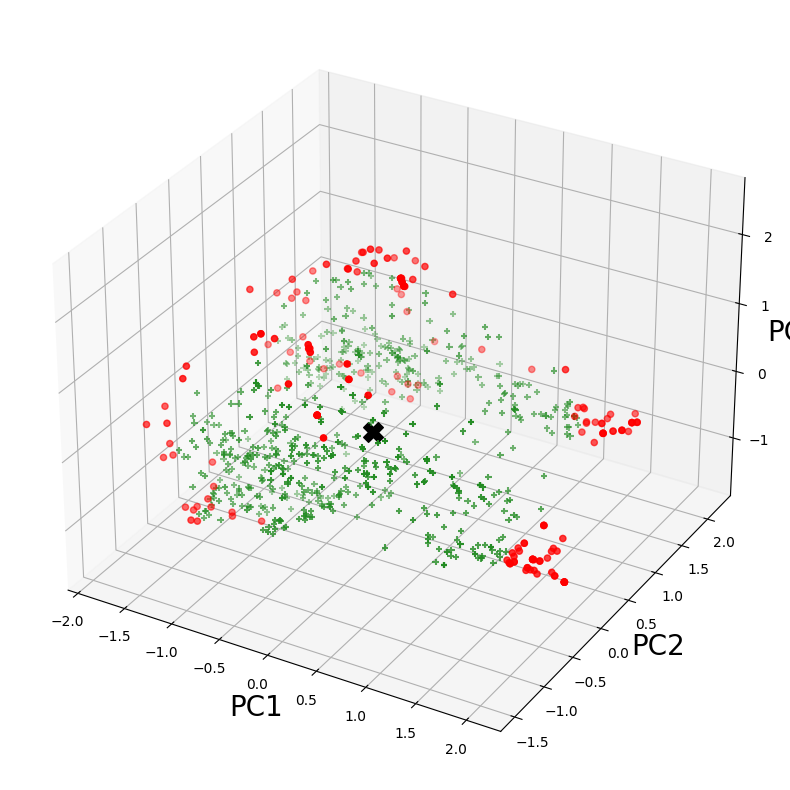

In [49]:
distance_matrix = pca_dataframe.apply(lambda x: distance_centroid(x, centroid_pca), axis=1)
q80 = distance_matrix.quantile(.799)
indices_lesst_q80 = distance_matrix[distance_matrix<q80].index
indices_aboveq80 = list(set(distance_matrix.index).symmetric_difference(set(indices_lesst_q80)))

# Create the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Generate the values
x_vals = pca_dataframe.pc1.loc[indices_lesst_q80]
y_vals = pca_dataframe.pc2.loc[indices_lesst_q80]
z_vals = pca_dataframe.pc3.loc[indices_lesst_q80]

x_ab = pca_dataframe.pc1.loc[indices_aboveq80]
y_ab = pca_dataframe.pc2.loc[indices_aboveq80]
z_ab = pca_dataframe.pc3.loc[indices_aboveq80]


# Plot the values
ax.scatter(x_vals, y_vals, z_vals, c = 'forestgreen', marker='+')
ax.scatter(x_ab, y_ab, z_ab, c = 'red', marker='o')
ax.scatter(centroid_pca[0],centroid_pca[1], centroid_pca[2], s=200, marker='X', color='black')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_zlabel('PC3', fontsize=20)


plt.show()


In [50]:
df_log['pca_split'] = df_log.index.to_series().apply(lambda x: 1 if x in indices_aboveq80 else 0)
df_log.pca_split.value_counts()

0    662
1    167
Name: pca_split, dtype: int64

In [51]:
167/(208+621)

0.2014475271411339

In [52]:
df_log.to_csv("C:/intern/solubility_data.csv")

In [61]:
# Data paths
target_path = "C:/intern/solubility_final.csv"
fingerprint_path =  "C:/intern/fingerprint_final.csv"
descriptor_path = "C:/intern/descriptor_final.csv"

experiments/run_indi_model_lasso.py

In [56]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

# winning model parameters
# ==================
# regressor_result_key-all_test-rand_preprocess-False.pickle
# {'train_score': 0.662546, 'validation_score': 0.957961,
# 'test_score': 0.696395}

predictive_set_key = 'all'
splitter_option = 'rand'

preproc_decision = False
random_seed = 42
alpha = 0.0150523354781535
params = {'fit_intercept': False, 'max_iter': 1000,
          'alpha': float(alpha), 'random_state': 42, 'tol': 0.01}

if __name__ == '__main__':
    df_log, df_fp, df_desc, df_all, predictive_dataset = load_data()
    train_pick, val_pick, test_pick, train_rand, test_rand, train_pca, test_pca = split_rand_pick(df_log,
                                                                                                  'diversity',
                                                                                                  'random',
                                                                                                  'pca_split')

    X = set_x_matrix(predictive_dataset, predictive_set_key, preprocess=preproc_decision)
    y = df_log.logS0

    X_train, X_val, X_ext, y_train, y_val, y_ext = return_sets(splitter_option, X, y, train_pick,
                                                               val_pick, test_pick, train_rand,
                                                               test_rand, train_pca, test_pca)

    print('===============', X_train.shape, y_ext.shape)

    model = Lasso(**params)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_ext)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    val_score = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_score = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_score = np.sqrt(mean_squared_error(y_ext, y_pred_test))


    scores = {'Train': train_score, 'Validation': val_score, 'Test': test_score}
    print(scores)

    pd.Series(y_pred_test, index=y_ext.index, name='lasso').to_csv('/content/drive/MyDrive/Chem Dataset FINAL/results/test_lasso_predicted.csv')
    y_ext.to_csv('/content/drive/MyDrive/Chem Dataset FINAL/results/test_true.csv')

Preprocessing  (829, 5437)  to  (829, 5437)
=============== (530, 5437) (166,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+02, tolerance: 4.145e+01
  model = cd_fast.enet_coordinate_descent(


{'Train': 0.6625462197225582, 'Validation': 0.957961151629105, 'Test': 0.6963947677484571}


experiments/run_indi_model_rf.py

In [58]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

# winning model parameters
# ==================
# regressor_result_key-all_test-rand_preprocess-False.pickle
# {'train_score': 0.4723311329495703, 'mean_score': 0.8299982962282464, 'validation_score': 0.9376601479621512,
# 'test_score': 0.7223364444943414}

features = ['Molecular_properties_AMR', 'Constitutional_indices_SCBO', 'Ring_descriptors_D/Dtr06',
            'Molecular_properties_MLOGP', 'Molecular_properties_BLTD48', 'Molecular_properties_BLTF96',
            'Ring_descriptors_Rperim', 'Constitutional_indices_C%', 'Constitutional_indices_nCsp2',
            'Functional_group_counts_nCar', 'Molecular_properties_BLTA96', 'fp4582', 'Topological_indices_ICR',
            'Functional_group_counts_nROH', 'Topological_indices_MAXDN', 'Molecular_properties_TPSA(Tot)',
            'Constitutional_indices_nC']

predictive_set_key = 'all'
splitter_option = 'rand'
#splitter_option = 'pca_split'
preproc_decision = False
random_seed = 42

params = {'bootstrap': True, 'max_depth': int(18.52203732903717), 'max_samples': float(0.5907891410962993),
          'min_samples_split': int(3.1474161594606516), 'n_estimators': int(247.25842336056604), 'random_state': 42}

if __name__ == '__main__':
    df_log, df_fp, df_desc, df_all, predictive_dataset = load_data()
    train_pick, val_pick, test_pick, train_rand, test_rand, train_pca, test_pca = split_rand_pick(df_log,
                                                                                                  'diversity',
                                                                                                  'random',
                                                                                                  'pca_split')

    X = set_x_matrix(predictive_dataset, predictive_set_key, preprocess=preproc_decision)
    y = df_log.logS0
    X_train, X_val, X_ext, y_train, y_val, y_ext = return_sets(splitter_option, X, y, train_pick,
                                                               val_pick, test_pick, train_rand,
                                                               test_rand, train_pca, test_pca)

    model = RandomForestRegressor(**params)
    model.fit(X_train[features], y_train)

    y_pred_test = model.predict(X_ext[features])
    y_pred_train = model.predict(X_train[features])
    y_pred_val = model.predict(X_val[features])

    val_score = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_score = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_score = np.sqrt(mean_squared_error(y_ext, y_pred_test))

    scores = {'Train': train_score, 'Validation': val_score, 'Test': test_score}
    print(scores)
    pd.Series(y_pred_test, index=y_ext.index, name='rf').to_csv('/content/drive/MyDrive/Chem Dataset FINAL/results/test_rf_predicted.csv')

Preprocessing  (829, 5437)  to  (829, 5437)
{'Train': 0.47263630176807325, 'Validation': 0.9390128644625835, 'Test': 0.7212356018397095}


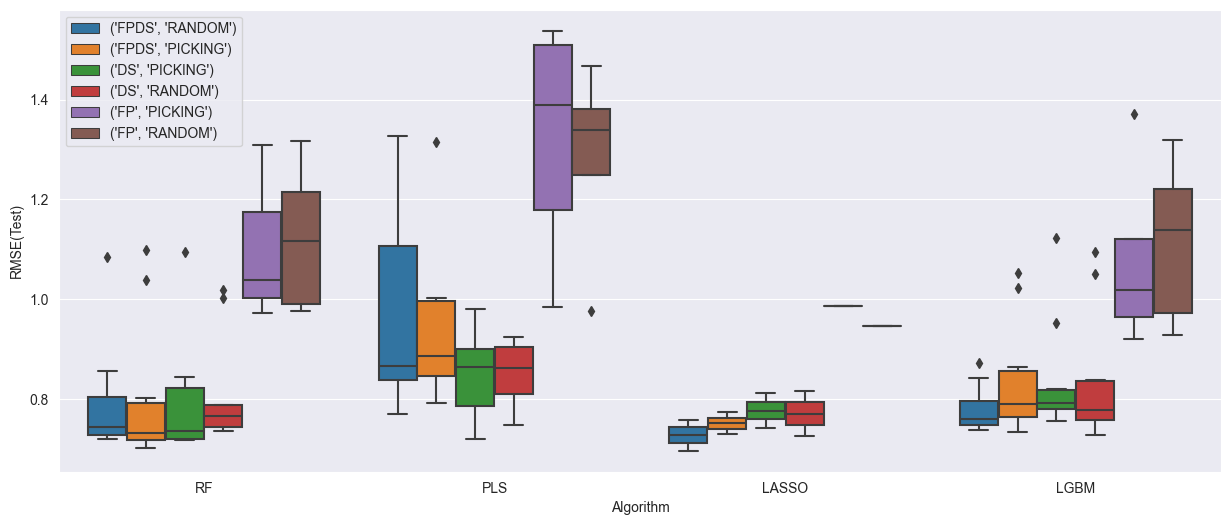

,ID,Index,Algorithm,Data,Split type,Preprocessed,RMSE(Test),Rank RMSE(Test),Features employed,Rank Features,RMSE(Train),RMSE(Validation),RMSE(Test/Train),RMSE(Test/Validation),delta(Test-Train),Rank(delta(Test-Train)),delta(Test-Val),Rank(delta(Test-Validation)),RkM score
0,lasso_0_FPDS_RANDOM_FALSE_105,lasso_0,LASSO,FPDS,RANDOM,False,0.696395,1,105,119,0.662546,0.957961,1.051089,0.726955,0.033849,26,0.261566,139,52.7
1,rf_0_FPDS_PICKING_TRUE_598,rf_0,RF,FPDS,PICKING,True,0.702059,2,598,140,0.510079,0.617154,1.376372,1.137574,0.191980,87,0.084904,20,53.7
2,rf_2_FPDS_PICKING_FALSE_16,rf_2,RF,FPDS,PICKING,False,0.713532,3,16,64,0.525990,0.594062,1.356550,1.201106,0.187542,85,0.119470,39,33.1
3,rf_1_DS_PICKING_TRUE_34,rf_1,RF,DS,PICKING,True,0.716986,4,34,87,0.516684,0.628871,1.387667,1.140117,0.200301,94,0.088115,23,39.8
4,rf_0_FPDS_PICKING_FALSE_5437,rf_0,RF,FPDS,PICKING,False,0.718057,5,5437,152,0.521017,0.581525,1.378183,1.234782,0.197040,91,0.136532,51,68.9


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

# Read data from Excel file
df1 = pd.read_excel("C:/intern/TableS3.xlsx")

# Create and display the box plot
plt.figure(figsize=(15, 6))
sns.boxplot(x=df1['Algorithm'],
            y=df1['RMSE(Test)'],
            order=['RF', 'PLS', 'LASSO', 'LGBM'],
            hue=df1[['Data', 'Split type']].apply(tuple, axis=1))
plt.show()

# Display the first few rows of the DataFrame
df1.head()


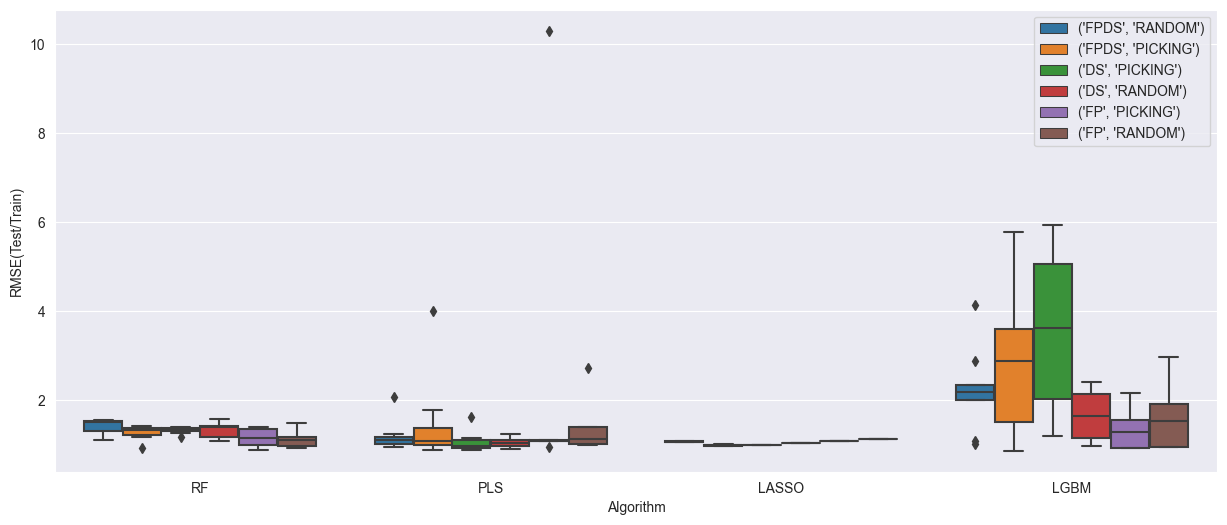

,ID,Index,Algorithm,Data,Split type,Preprocessed,RMSE(Test),Rank RMSE(Test),Features employed,Rank Features,RMSE(Train),RMSE(Validation),RMSE(Test/Train),RMSE(Test/Validation),delta(Test-Train),Rank(delta(Test-Train)),delta(Test-Val),Rank(delta(Test-Validation)),RkM score
0,lasso_0_FPDS_RANDOM_FALSE_105,lasso_0,LASSO,FPDS,RANDOM,False,0.696395,1,105,119,0.662546,0.957961,1.051089,0.726955,0.033849,26,0.261566,139,52.7
1,rf_0_FPDS_PICKING_TRUE_598,rf_0,RF,FPDS,PICKING,True,0.702059,2,598,140,0.510079,0.617154,1.376372,1.137574,0.191980,87,0.084904,20,53.7
2,rf_2_FPDS_PICKING_FALSE_16,rf_2,RF,FPDS,PICKING,False,0.713532,3,16,64,0.525990,0.594062,1.356550,1.201106,0.187542,85,0.119470,39,33.1
3,rf_1_DS_PICKING_TRUE_34,rf_1,RF,DS,PICKING,True,0.716986,4,34,87,0.516684,0.628871,1.387667,1.140117,0.200301,94,0.088115,23,39.8
4,rf_0_FPDS_PICKING_FALSE_5437,rf_0,RF,FPDS,PICKING,False,0.718057,5,5437,152,0.521017,0.581525,1.378183,1.234782,0.197040,91,0.136532,51,68.9


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

# Read data from Excel file
df1 = pd.read_excel("C:/intern/TableS3.xlsx")

# Create and display the box plot
plt.figure(figsize=(15, 6))
sns.boxplot(x=df1['Algorithm'],
            y=df1['RMSE(Test/Train)'],
            order=['RF', 'PLS', 'LASSO', 'LGBM'],
            hue=df1[['Data', 'Split type']].apply(tuple, axis=1))
plt.show()

# Display the first few rows of the DataFrame
df1.head()